# Lattice Boltzmann code: D2Q9

### Implement
$$
f_i(\mathbf{r}_{jk}+\mathbf{c}_i\cdot\Delta t,t+\Delta t)=f_i(\mathbf{r}_{jk},t)
   - \omega\left(f_i(\mathbf{r}_{jk},t)-
     f^{\text{eq}}_i(\rho(\mathbf{r}_{jk}, t),\mathbf{u}(\mathbf{r}_{jk}, t),T(\mathbf{r}_{jk}, t))\right)
$$
### Where
$$
f_i^{\text{eq}}(\mathbf{r}_{jk},t)=w_i\rho(\mathbf{r}_{jk}, t)\left\{1 + 3\mathbf{c}_i \mathbf{u}(\mathbf{r}_{jk}, t)
+\frac{9}{2}\left(\mathbf{c}_i \mathbf{u}(\mathbf{r}_{jk}, t)\right)^2-\frac{3}{2}\mathbf{u}^2(\mathbf{r}_{jk}, t)\right\}
$$
### This code is for the shear wave decay problem
So in order to set up a shear wave as initial condition you need to do
$$
\mathbf{u}(\mathbf{r}) = u_0\begin{pmatrix}\sin(\frac{2\pi n}{H}y)\\0 \end{pmatrix}
$$
This means that the shear wave does not depend on $x$. This shear wave Amplitude $u(t)$ should decay analytically as $u(t)=u_0e^{-\nu\left(\frac{2\pi n}{H}\right)^2t}$

The shear viscosity in our case is calculated as $\nu=\frac{1}{3}\left(\frac{1}{\omega}-\frac{1}{2}\right)$. So calculating the decay and fitting an expontential to it
we could see if the analytical and numerical expressions for $\nu$ correspond. Careful: $u_0<.1$ and $0<omega<1.7$

In [13]:
# What it needs

import numpy as np
#import scipy.sparse as sp
#import scipy.sparse.linalg as la
#from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
#import matplotlib.patches as patches
import time


### Auxiliary functions

Calculate the local equilibrium distribution function
Set the initial conditions

In [14]:
# Function to calculate the equilibrium distribution
def equilibrium(rho, u):
    cdot3u = 3 * np.einsum('ai,axy->ixy', c, u)    # This is 3*c*u
    usq = np.einsum('axy->xy', u*u)                # This is u^2
    wrho=np.einsum('i,xy->ixy', w, rho)            
    feq = wrho * (1 + cdot3u*(1 + 0.5*cdot3u) - 1.5*usq[np.newaxis,:,:])
    return feq
# Define the streaming function
def Stream(g):
    for i in range(1,9):
        g[i,:,:] = np.roll(g[i,:,:], c.T[i], axis=[0,1])
    return g
# Define the scattering function
def Collide(g):
    rho = np.einsum('ijk->jk',g)
    u = np.einsum('ai,ixy->axy',c,g)/rho
    feq = equilibrium(rho,u)
    g = g + omega*(feq-g)
    return g

### Set up the simulation
To this end we also have to define the array holding the streaming channels,
read in the grid size parameters

In [17]:
# dimensions of the 2D lattice and the Lattice parameters
NX=60 #int(input("nx = "))
NY=40 #int(input("ny = "))
# simulation parameters
scale  = 1               # set simulation size
#NX     = 32*scale        # domain size
#NY     = NX
NSTEPS = 200*scale*scale # number of simulation time steps
NMSG   = 50*scale*scale  # show messages every NMSG time steps
vis    = False           # show visualisation; set to False for performance measurements
NVIS   = NMSG            # show visualisation every NVIS time steps
omega  = 1.5
tau    = 1/omega               # relaxation time
u_max  = 0.1/scale      # maximum velocity
nu     = (1/omega-1/2)/3     # kinematic shear viscosity
rho0   = 1.0               # rest density
#Re     = NX*u_max/nu     # Reynolds number; not used in the simulation itself
#
# Define the wights and channel velocities
w = np.array([4/9, 1/9, 1/9, 1/9, 1/9, 1/36, 1/36, 1/36, 1/36]) # weights
c = np.array([[0, 1, 0, -1,  0, 1, -1, -1,  1],  # velocities, x components
              [0, 0, 1,  0, -1, 1,  1, -1, -1]]) # velocities, y components
#
# Define the gridpoints
x = np.arange(NX)+0.5    # the position of the points is half-ways in the interval
y = np.arange(NY)+0.5
X,Y = np.meshgrid(x,y)
# Initialize the density with 1.0 and the velocity with a sinusoidal
rho=np.ones((NX,NY))
n = 1           # multiples of the basic wavenumber try to play with n
k = 2*np.pi*n/NY  # Wavenumbers
u = np.array([u_max*np.sin(k*Y.T),np.zeros((NX,NY))])
f = equilibrium(rho,u) # create a local equilibrium initial condition. Note the term "local" it will decay due to viscosity

Elapsed time: 4.533539533615112


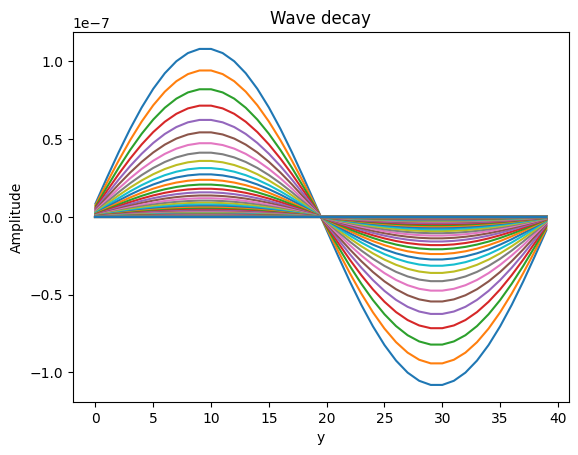

In [19]:
amp=np.array(u[0,NX//2,NY//8]) # The amplitud of u in time
#
start = time.time()

fig, ax = plt.subplots()
ax.plot(u[0,NX//2,:])
ax.set_title('Wave decay')
ax.set_xlabel('y')
ax.set_ylabel('Amplitude')
for n in range(1,10001):
    f = Stream(f)
    f = Collide(f)
    if n%100==0:
        #Tmeasure=np.append(Tmeasure,np.array(time))
        u = np.einsum('ai,ixy->axy',c,f)/rho  
        ax.plot(u[0,NX//2,:])
        amp=np.append(amp,u[0,NX//2,NY//8])

    
np.linalg.norm(X)
print("Elapsed time:", time.time() - start)
#    

Text(0, 0.5, 'Amplitude')

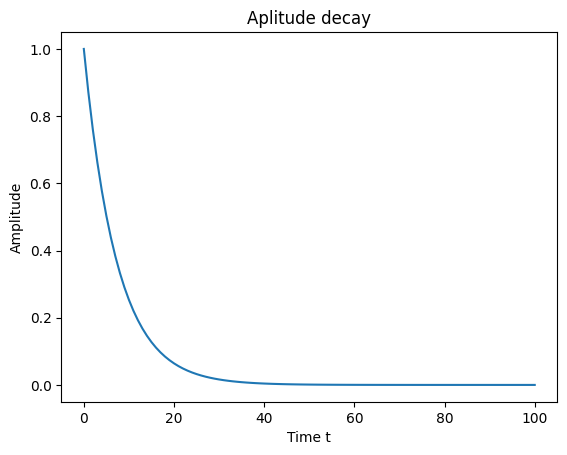

In [20]:
# Plotting the amplitude decay
fig, ax = plt.subplots()
ax.plot(amp/amp[0])
ax.set_title('Aplitude decay')
ax.set_xlabel('Time t')
ax.set_ylabel('Amplitude')